# Intro:
This is an implementation of this: https://arxiv.org/pdf/2212.10717 paper on a Resnet34 model using CIFAR100

## Load Data

In [2]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from dataclasses import dataclass, field
from tqdm import tqdm
import os
import time
import subprocess
import threading
import psutil
import GPUtil  # You might need to install: pip install gputil
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetUtilizationRates  # pip install nvidia-ml-py3


def optimize_for_speed(module_list=None):
    """Apply speed optimizations that don't require code changes"""
    # Set environment variables for better performance
    os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
    os.environ["TORCH_CUDNN_V8_API_ENABLED"] = "1"
    
    # Use TF32 on Ampere GPUs for faster mixed precision (negligible accuracy loss)
    t.backends.cuda.matmul.allow_tf32 = True
    t.backends.cudnn.allow_tf32 = True
    
    # Enable cuDNN benchmarking
    t.backends.cudnn.benchmark = True
    
    # If using PyTorch 2.0+, compile your model
    if hasattr(t, 'compile') and module_list:
        for module in module_list:
            t.compile(module)

    # Clear GPU cache
    t.cuda.empty_cache()
    
    print("Speed optimizations applied")
    

def get_dataset():
    # CIFAR100 Mean and Std
    mean = (0.5071, 0.4867, 0.4408)
    std = (0.2675, 0.2565, 0.2761)

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    # Load the CIFAR-100 training and test datasets
    trainset = tv.datasets.CIFAR100(root='data', train=True,
                        download=True, transform=transform_train)

    testset = tv.datasets.CIFAR100(root='data', train=False,
                        download=True, transform=transform_test)
    return trainset, testset

trainset, testset = get_dataset()
classes = trainset.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4487329..1.5126765].


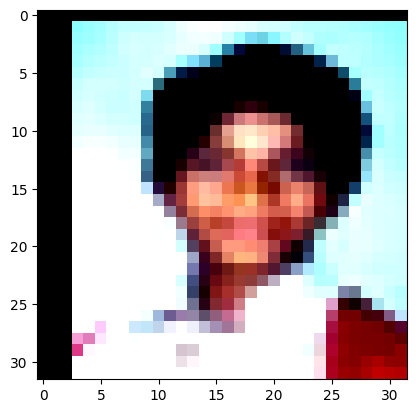

boy


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img: t.Tensor):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# Get a random image from the trainset
image, label = trainset[3]

# Display the image
imshow(image)
print(classes[label])

## Train Loop

In [4]:
def gpu_monitoring_thread(stop_event, log_file='gpu_stats.csv'):
    """Thread function to monitor GPU usage and log it to a file."""
    try:
        nvmlInit()
        device_handle = nvmlDeviceGetHandleByIndex(0)  # First GPU
        
        # Create log file and write header
        with open(log_file, 'w') as f:
            f.write("timestamp,gpu_util(%),memory_used(MB),memory_total(MB),memory_util(%),temperature(C)\n")
        
        last_printed = 0  # To limit console output frequency
        while not stop_event.is_set():
            try:
                # Get GPU statistics
                util = nvmlDeviceGetUtilizationRates(device_handle)
                mem_info = nvmlDeviceGetMemoryInfo(device_handle)
                
                # Format and log statistics
                timestamp = time.time()
                gpu_util = util.gpu
                mem_used = mem_info.used / 1024 / 1024  # Convert to MB
                mem_total = mem_info.total / 1024 / 1024  # Convert to MB
                mem_util = 100 * mem_info.used / mem_info.total
                
                # Get GPU temperature (optional, may not work on all GPUs)
                gpu_temp = GPUtil.getGPUs()[0].temperature
                
                # Write to log file
                with open(log_file, 'a') as f:
                    f.write(f"{timestamp},{gpu_util},{mem_used:.2f},{mem_total:.2f},{mem_util:.2f},{gpu_temp}\n")
                
                # Print current stats to console less frequently (every 5 seconds)
                current_time = time.time()
                if current_time - last_printed >= 5:
                    print(f"\rGPU: {gpu_util}% | Mem: {mem_used/1024:.1f}/{mem_total/1024:.1f}GB ({mem_util:.1f}%)", end="", flush=True)
                    last_printed = current_time
                
                # Sleep until next update
                time.sleep(1)  # Update every second
            
            except Exception as e:
                print(f"Error in GPU monitoring: {e}")
                time.sleep(5)  # Retry after 5 seconds
    
    except Exception as e:
        print(f"Failed to initialize GPU monitoring: {e}")


def setup_nvidia_smi_logging(log_interval=5, log_file="nvidia_smi_log.txt"):
    """Start a separate process to log nvidia-smi output at regular intervals"""
    # First clear the log file if it exists
    with open(log_file, 'w') as f:
        f.write(f"NVIDIA-SMI Log started at {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
    
    # Command to run nvidia-smi periodically and log to file (use > instead of >> to overwrite each time)
    # Use a compact format with only essential information
    cmd = f'while true; do (echo "$(date)" && nvidia-smi --format=csv,noheader --query-gpu=utilization.gpu,memory.used,memory.total,temperature.gpu,power.draw) > {log_file}; sleep {log_interval}; done'
    process = subprocess.Popen(cmd, shell=True)
    return process


In [6]:
from dataclasses import dataclass, field
from tqdm import tqdm

@dataclass
class ResNetTrainingArgs:
    batch_size: int = 128
    epochs: int = 200
    n_classes: int = 100
    optimizer: t.optim.Optimizer = t.optim.SGD
    optimizer_args: dict[str, float] = field(default_factory=lambda: {"lr": 0.1, "momentum": 0.9, "weight_decay": 5e-4})
    scheduler: t.optim.lr_scheduler = t.optim.lr_scheduler.MultiStepLR
    scheduler_args: dict[str, float] = field(default_factory=lambda: {"milestones": [60, 120, 160], "gamma": 0.2})
    mixed_precision: bool = True
    num_workers: int = 8
    pin_memory: bool = True
    prefetch_factor: int = 2
    benchmark: bool = True
    compile_model: bool = True
    gradient_accumulation_steps: int = 1
    monitor_gpu: bool = True
    monitor_interval: float = 5.0  # seconds between GPU monitoring updates


def train_and_validate(args: ResNetTrainingArgs, model: nn.Module, device: t.device) -> tuple[list[float], list[float], list[float], nn.Module]:
    """
    Trains and validates the ResNet model with optimized performance.
    """
    # Enable cuDNN benchmarking for faster convolutions
    if args.benchmark:
        t.backends.cudnn.benchmark = True

    # Use PyTorch 2.0+ model compilation for faster execution
    if args.compile_model and hasattr(t, 'compile'):
        model = t.compile(model)
    
    optimizer = args.optimizer(model.parameters(), **args.optimizer_args)
    scheduler = args.scheduler(optimizer, **args.scheduler_args)
    
    # Initialize gradient scaler for mixed precision training - updated to newer PyTorch API
    scaler = GradScaler(device='cuda', enabled=args.mixed_precision)

    # Load dataset with optimized DataLoader settings
    trainset, testset = get_dataset()
    trainloader = DataLoader(
        trainset, 
        batch_size=args.batch_size, 
        shuffle=True, 
        num_workers=args.num_workers,
        pin_memory=args.pin_memory,
        prefetch_factor=args.prefetch_factor,
        persistent_workers=True
    )
    
    testloader = DataLoader(
        testset, 
        batch_size=args.batch_size * 2,  # Can use larger batch size for inference
        shuffle=False, 
        num_workers=args.num_workers,
        pin_memory=args.pin_memory,
        prefetch_factor=args.prefetch_factor,
        persistent_workers=True
    )
    
    # Start GPU monitoring if requested
    stop_monitoring = threading.Event()
    monitoring_thread = None
    if args.monitor_gpu:
        print("Starting GPU monitoring...")
        monitoring_thread = threading.Thread(
            target=gpu_monitoring_thread, 
            args=(stop_monitoring,),
            daemon=True
        )
        monitoring_thread.start()

    # Lists to store metrics
    loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(args.epochs):
        model.train()
        pbar_train = tqdm(trainloader, desc=f"Epoch {epoch+1}/{args.epochs}")

        total_train = 0
        correct_train = 0
        running_loss = 0.0
        
        # Zero gradients at the beginning of each epoch rather than each batch
        optimizer.zero_grad()

        for i, (imgs, labels) in enumerate(pbar_train):
            # Move data to device with non-blocking transfer
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Use mixed precision training - updated to newer PyTorch API
            with autocast(device_type='cuda', enabled=args.mixed_precision):
                logits = model(imgs)
                loss = F.cross_entropy(logits, labels)
                loss = loss / args.gradient_accumulation_steps  # Scale loss for gradient accumulation
            
            # Use gradient scaling to prevent underflow
            scaler.scale(loss).backward()
            
            # Gradient accumulation - only update every n steps
            if (i + 1) % args.gradient_accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            # Update metrics
            with t.no_grad():
                running_loss += loss.item() * args.gradient_accumulation_steps
                predicted = t.argmax(logits, dim=-1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

            # Update progress bar
            train_accuracy = 100 * correct_train / total_train
            pbar_train.set_postfix(loss=f"{running_loss/(i+1):.3f}", train_acc=f"{train_accuracy:.2f}%")

        # Record metrics for the epoch
        epoch_loss = running_loss / len(trainloader)
        loss_list.append(epoch_loss)
        train_accuracy_list.append(train_accuracy)

        # ----------------------
        # Validation Loop
        # ----------------------
        model.eval()
        correct_val = 0
        total_val = 0

        with t.inference_mode():
            for imgs, labels in testloader:
                imgs = imgs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                with autocast(device_type='cuda', enabled=args.mixed_precision):
                    logits = model(imgs)
                
                predicted = t.argmax(logits, dim=-1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = 100 * correct_val / total_val
        val_accuracy_list.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{args.epochs}] - Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")

        scheduler.step()
    
    # Stop GPU monitoring if it was started
    if args.monitor_gpu and monitoring_thread is not None:
        stop_monitoring.set()
        monitoring_thread.join(timeout=1.0)
        print("\nGPU monitoring stopped")

    return loss_list, train_accuracy_list, val_accuracy_list, model


In [ ]:
from widenet import WideNet
    
# Use CUDA by default for L40s GPU
device = t.device("cuda")
print(f"Using device: {device}")

if t.cuda.is_available():
  print(f"GPU: {t.cuda.get_device_name(0)}")
  print(f"CUDA Version: {t.version.cuda}")
  print(f"Number of GPUs: {t.cuda.device_count()}")
  
  # Print GPU memory info before training
  print("\nGPU Memory before training:")
  for i in range(t.cuda.device_count()):
      print(f"GPU {i}: {t.cuda.get_device_properties(i).name}")
      print(f"  Total memory: {t.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")
      print(f"  Memory allocated: {t.cuda.memory_allocated(i) / 1024**3:.2f} GB")
      print(f"  Memory reserved: {t.cuda.memory_reserved(i) / 1024**3:.2f} GB")

# Optional: Start nvidia-smi logging in background
nvidia_smi_process = setup_nvidia_smi_logging(log_interval=10)

# Optimized training arguments
training_args = ResNetTrainingArgs(
  batch_size=256,                 # Increased batch size for better GPU utilization
  epochs=200,
  n_classes=100,
  optimizer=t.optim.SGD,
  optimizer_args={"lr": 0.1, "momentum": 0.9, "weight_decay": 5e-4},
  scheduler=t.optim.lr_scheduler.MultiStepLR,
  scheduler_args={"milestones": [60, 120, 160], "gamma": 0.2},
  mixed_precision=True,          # Enable mixed precision training
  num_workers=8,                 # Optimize based on CPU cores
  pin_memory=True,               # Speed up CPU to GPU transfers
  prefetch_factor=2,             # Prefetch batches for better throughput
  benchmark=True,                # Enable cuDNN benchmarking
  compile_model=True,            # Use PyTorch 2.0+ compilation
  gradient_accumulation_steps=1, # Increase if OOM errors occur
  monitor_gpu=True,              # Enable GPU monitoring
  monitor_interval=5.0           # Update monitoring stats every 5 seconds
)

# Initialize model
widenet28 = WideNet(n_classes=100).to(device)

Using device: cuda
GPU: NVIDIA L40S
CUDA Version: 12.4
Number of GPUs: 4

GPU Memory before training:
GPU 0: NVIDIA L40S
  Total memory: 44.43 GB
  Memory allocated: 1.23 GB
  Memory reserved: 1.53 GB
GPU 1: NVIDIA L40S
  Total memory: 44.43 GB
  Memory allocated: 0.00 GB
  Memory reserved: 0.00 GB
GPU 2: NVIDIA L40S
  Total memory: 44.43 GB
  Memory allocated: 0.00 GB
  Memory reserved: 0.00 GB
GPU 3: NVIDIA L40S
  Total memory: 44.43 GB
  Memory allocated: 0.00 GB
  Memory reserved: 0.00 GB


In [ ]:
# Train the model
loss_list, train_accuracy_list, val_accuracy_list, trained_model = train_and_validate(
  training_args, widenet28, device
)

print("Training completed!")

# Kill nvidia-smi logging process if it was started
if 'nvidia_smi_process' in locals():
  nvidia_smi_process.terminate()
  print("Nvidia-smi logging stopped")

# Print GPU memory info after training
if t.cuda.is_available():
  print("\nGPU Memory after training:")
  for i in range(t.cuda.device_count()):
    print(f"GPU {i}: {t.cuda.get_device_properties(i).name}")
    print(f"  Memory allocated: {t.cuda.memory_allocated(i) / 1024**3:.2f} GB")
    print(f"  Memory reserved: {t.cuda.memory_reserved(i) / 1024**3:.2f} GB")
      
print("\nTraining statistics have been saved to:")
print("- gpu_stats.csv - Detailed GPU utilization metrics")
print("- nvidia_smi_log.txt - Raw nvidia-smi output logs")

In [16]:
from typing import OrderedDict

# Initialize model
widenet28 = WideNet(n_classes=100).to(device)

checkpoint_path = "checkpoints/widenet_best.pt"

# Load the checkpoint
checkpoint = t.load(checkpoint_path)


untrained_model_state = widenet28.state_dict()
checkpoint_model_state: OrderedDict = checkpoint["model_state_dict"]

state_to_load = {
  key: pretrained_value for (key, value), (pretrained_key, pretrained_value) in zip(untrained_model_state.items(), checkpoint_model_state.items())
}

# Load the model weights
widenet28.load_state_dict(state_to_load)

# Set the model to evaluation mode
widenet28.eval()


print("Model weights loaded successfully!")

Model weights loaded successfully!


In [21]:
correct_val = 0
total_val = 0
val_accuracy_list = []

testloader = DataLoader(
  testset, 
  batch_size=training_args.batch_size * 2,  # Can use larger batch size for inference
  shuffle=False, 
  num_workers=training_args.num_workers,
  pin_memory=training_args.pin_memory,
  prefetch_factor=training_args.prefetch_factor,
  persistent_workers=True
)

with t.inference_mode():
  for imgs, labels in testloader:
    imgs = imgs.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    
    with autocast(device_type='cuda', enabled=training_args.mixed_precision):
      logits = widenet28(imgs)
    
    predicted = t.argmax(logits, dim=-1)
    correct_val += (predicted == labels).sum().item()
    total_val += labels.size(0)

val_accuracy = 100 * correct_val / total_val

val_accuracy

79.09